In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer, SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid
from sklearn.decomposition import PCA


#import knn classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestClassifier
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error,  mean_squared_error, r2_score, accuracy_score




In [49]:
train = pd.read_csv('data/train.csv')
train2 = pd.read_csv('data/training_extra.csv')
test = pd.read_csv('data/test.csv')


In [50]:
train = pd.concat([train, train2], axis=0)
train.reset_index(inplace=True, drop=True)
train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


### Encode Categories

In [51]:
train.shape

(3994318, 11)

In [52]:
cat_cols = ['Brand', 'Material', 'Size', 'Style', 'Color', 'Laptop Compartment', 'Waterproof']

# fill na with 'Unknown'

for col in cat_cols:
    train[col] = train[col].fillna('Unknown')
    test[col] = test[col].fillna('Unknown')


# encode the categorical columns using one-hot encoding

train_ohe = pd.get_dummies(train, columns=cat_cols, drop_first=False)
test_ohe = pd.get_dummies(test, columns=cat_cols, drop_first=False)

train = pd.concat([train[cat_cols], train_ohe], axis=1)
test = pd.concat([test[cat_cols], test_ohe], axis=1)



In [53]:
train.columns

Index(['Brand', 'Material', 'Size', 'Style', 'Color', 'Laptop Compartment',
       'Waterproof', 'id', 'Compartments', 'Weight Capacity (kg)', 'Price',
       'Brand_Adidas', 'Brand_Jansport', 'Brand_Nike', 'Brand_Puma',
       'Brand_Under Armour', 'Brand_Unknown', 'Material_Canvas',
       'Material_Leather', 'Material_Nylon', 'Material_Polyester',
       'Material_Unknown', 'Size_Large', 'Size_Medium', 'Size_Small',
       'Size_Unknown', 'Style_Backpack', 'Style_Messenger', 'Style_Tote',
       'Style_Unknown', 'Color_Black', 'Color_Blue', 'Color_Gray',
       'Color_Green', 'Color_Pink', 'Color_Red', 'Color_Unknown',
       'Laptop Compartment_No', 'Laptop Compartment_Unknown',
       'Laptop Compartment_Yes', 'Waterproof_No', 'Waterproof_Unknown',
       'Waterproof_Yes'],
      dtype='object')

In [54]:
cat_cols = ['Brand', 'Material', 'Size', 'Style', 'Color',  'Laptop Compartment', 'Waterproof']

# group by brand, material, size, style, color, laptop compartment, waterproof and average price

for col in cat_cols:
    map_dict = (train.groupby([col])['Price'].mean().reset_index().sort_values(by='Price', ascending=True))
    map_dict = dict(zip(map_dict[col], range(0,map_dict.shape[0])))

    new_col = col + '_enc'

    train[new_col] = train[col].map(map_dict)
    test[new_col] = test[col].map(map_dict)
    

In [55]:
train.columns

Index(['Brand', 'Material', 'Size', 'Style', 'Color', 'Laptop Compartment',
       'Waterproof', 'id', 'Compartments', 'Weight Capacity (kg)', 'Price',
       'Brand_Adidas', 'Brand_Jansport', 'Brand_Nike', 'Brand_Puma',
       'Brand_Under Armour', 'Brand_Unknown', 'Material_Canvas',
       'Material_Leather', 'Material_Nylon', 'Material_Polyester',
       'Material_Unknown', 'Size_Large', 'Size_Medium', 'Size_Small',
       'Size_Unknown', 'Style_Backpack', 'Style_Messenger', 'Style_Tote',
       'Style_Unknown', 'Color_Black', 'Color_Blue', 'Color_Gray',
       'Color_Green', 'Color_Pink', 'Color_Red', 'Color_Unknown',
       'Laptop Compartment_No', 'Laptop Compartment_Unknown',
       'Laptop Compartment_Yes', 'Waterproof_No', 'Waterproof_Unknown',
       'Waterproof_Yes', 'Brand_enc', 'Material_enc', 'Size_enc', 'Style_enc',
       'Color_enc', 'Laptop Compartment_enc', 'Waterproof_enc'],
      dtype='object')

### Feature Imputation

In [56]:
print(train.isna().sum().sum())


1808


In [57]:
print(train.isna().sum().sum())

num_cols = [col for col in train.columns if train[col].dtype in ['float64', 'int64']]
num_cols.remove('Price')

for col in num_cols:
    train.fillna({col:train[col].mean()}, inplace=True)
    test.fillna({col:test[col].mean()}, inplace=True)
print(train.isna().sum().sum())

1808
0


### Feature Engineering 

In [58]:
def engineer_features(df):

    columns = [col.lower() for col in df.columns]
    df.columns = columns

    df = df.rename(columns={'weight capacity (kg)':'weight_capacity'})


    df['weight_capacity_rounded'] = df['weight_capacity'].apply(lambda x: round(x))
    
    binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
    binned_values = binner.fit_transform(df[['weight_capacity_rounded']]).astype(int).flatten()

    # Create bin category column
    bin_col_name = f"weight_capacity_bins"
    df[bin_col_name] = binned_values

    df['weight_capacity_ratio'] = df['weight_capacity'] / df['weight_capacity'].max()

    df['weight_capacity_squared'] = df['weight_capacity'] ** 2

    df['weight_capacity_cubed'] = df['weight_capacity'] ** 3

    df['weight_to_compartments'] = df['weight_capacity'] / (df['compartments'] + 1)

    df['compartments_bins'] = pd.cut(df['compartments'], bins=[0, 2, 5, 10, np.inf], labels=['Few', 'Moderate', 'Many', 'Very Many'])
    df['compartments_bins'] = df['compartments_bins'].astype('category').cat.codes

    # interaction terms
    df['brand_material'] = df['brand'].astype(str) + '_' + df['material'].astype(str)
    df['brand_material'] = df['brand_material'].astype('category').cat.codes

    df['brand_size'] = df['brand'].astype(str) + '_' + df['size'].astype(str)
    df['brand_size'] = df['brand_size'].astype('category').cat.codes

    df['style_size'] = df['style'].astype(str) + '_' + df['size'].astype(str)
    df['style_size'] = df['style_size'].astype('category').cat.codes

    df['style_material'] = df['style'].astype(str) + '_' + df['material'].astype(str)
    df['style_material'] = df['style_material'].astype('category').cat.codes

    df['color_material'] = df['color'].astype(str) + '_' + df['material'].astype(str)
    df['color_material'] = df['color_material'].astype('category').cat.codes

    df['brand_avg_weight_capacity'] = df.groupby('brand')['weight_capacity'].transform('mean')
    df['style_avg_weight_capacity'] = df.groupby('style')['weight_capacity'].transform('mean')
    df['color_avg_weight_capacity'] = df.groupby('color')['weight_capacity'].transform('mean')
    df['compartments_avg_weight_capacity'] = df.groupby('compartments')['weight_capacity'].transform('mean')
    df['size_avg_weight_capacity'] = df.groupby('size')['weight_capacity'].transform('mean')

    df = df.drop(columns=['brand', 'material', 'size', 'style', 'color','laptop compartment', 'waterproof'])

    return df 

train = engineer_features(train)
test = engineer_features(test)



### Target Encoding

In [60]:
te_cols = ['brand_enc', 'material_enc', 'size_enc', 'style_enc',
       'color_enc', 'laptop compartment_enc', 'waterproof_enc',
       'weight_capacity_rounded', 'weight_capacity_bins',
       'weight_capacity_ratio', 'weight_capacity_squared',
       'weight_capacity_cubed', 'weight_to_compartments', 'compartments_bins',
       'brand_material', 'brand_size', 'style_size', 'style_material',
       'color_material', 'brand_avg_weight_capacity',
       'style_avg_weight_capacity', 'color_avg_weight_capacity',
       'compartments_avg_weight_capacity', 'size_avg_weight_capacity', 'compartments',
       'weight_capacity']

new_feature_cols = [feature + '_te' for feature in te_cols]

In [61]:

# Initialize KFold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for col in te_cols:
    print(col)
    # Create a new column to store the encoded values
    train[col + '_te'] = np.nan

    # Out-of-fold target encoding
    for train_idx, val_idx in kf.split(train):
        # Split data
        train_set, val_set = train.iloc[train_idx], train.iloc[val_idx]
        
        # Calculate category means on training data
        category_means = train_set.groupby(col)['price'].mean()
        
        # Encode validation fold using category means from the training fold
        train.loc[val_idx, col + '_te'] = train.loc[val_idx, col].map(category_means)

    # Fill any NaN values with the overall mean target
    overall_mean = train[col].mean()
    
    train.fillna({col + '_te':overall_mean}, inplace=True)  # Fill any NaN values with the overall mean target 

    final_category_means = train.groupby(col)['price'].mean()

    # Map the test set categories using the train set means
    test[col + '_te'] = test[col].map(final_category_means)

    # Fill NaN values in the test set with the overall mean
    test.fillna({col + '_te':overall_mean}, inplace=True)

brand_enc
material_enc
size_enc
style_enc
color_enc
laptop compartment_enc
waterproof_enc
weight_capacity_rounded
weight_capacity_bins
weight_capacity_ratio
weight_capacity_squared
weight_capacity_cubed
weight_to_compartments
compartments_bins
brand_material
brand_size
style_size
style_material
color_material
brand_avg_weight_capacity
style_avg_weight_capacity
color_avg_weight_capacity
compartments_avg_weight_capacity
size_avg_weight_capacity
compartments
weight_capacity


In [62]:
# encoder = TargetEncoder(cols=te_cols)

# train[new_feature_cols] = None
# train[new_feature_cols] = encoder.fit_transform(train[te_cols], train['price'])

# test[new_feature_cols] = None
# test[new_feature_cols] = encoder.transform(test[te_cols])

### Scaling

In [63]:
feature_cols = [col for col in train.columns if col not in ['id', 'price']]


In [64]:
scaler = StandardScaler()

train[feature_cols] = scaler.fit_transform(train[feature_cols])
test[feature_cols] = scaler.transform(test[feature_cols])

### PCA

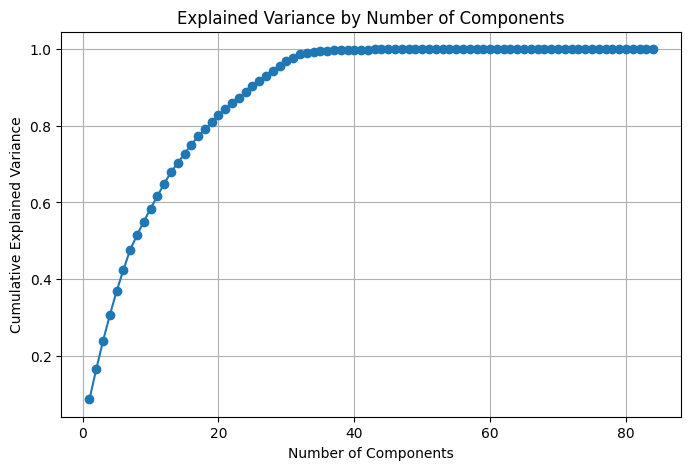

In [65]:
# Apply PCA
pca = PCA().fit(train[feature_cols])

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()


In [100]:
pca = PCA(n_components=26)  # Reduce to 19 components
X_pca = pca.fit_transform(train[feature_cols])
X_pca = pd.DataFrame(X_pca, columns=[f'PC_{i}' for i in range(1, X_pca.shape[1] + 1)])

test_pca = pca.transform(test[feature_cols])
test_pca = pd.DataFrame(test_pca, columns=[f'PC_{i}' for i in range(1, test_pca.shape[1] + 1)])

train = pd.concat([train, X_pca], axis=1)
test = pd.concat([test, test_pca], axis=1)

### CB Model

In [66]:

X = None 
y = None 

cb_params = {
    'iterations': [500],
    'learning_rate': [0.1],
    'depth': [4]
}

cb_model = cb.CatBoostRegressor(verbose=0, random_state=42, loss_function='RMSE')


# Grid search setups
def run_grid_search(model, params, name, scoring='neg_root_mean_squared_error', X=X, y=y):
    grid = GridSearchCV(model, params, cv=3, scoring=scoring, n_jobs=-1)
    grid.fit(X, y)
    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f"Best score for {name}: {-grid.best_score_}")
    return grid.best_estimator_


In [67]:
X = train[feature_cols]#X_pca#
y = train['price']
best_cb = run_grid_search(cb_model, cb_params, "CatBoost", X=X, y=y)


Best parameters for CatBoost: {'depth': 4, 'iterations': 500, 'learning_rate': 0.1}
Best score for CatBoost: 38.68885261109418


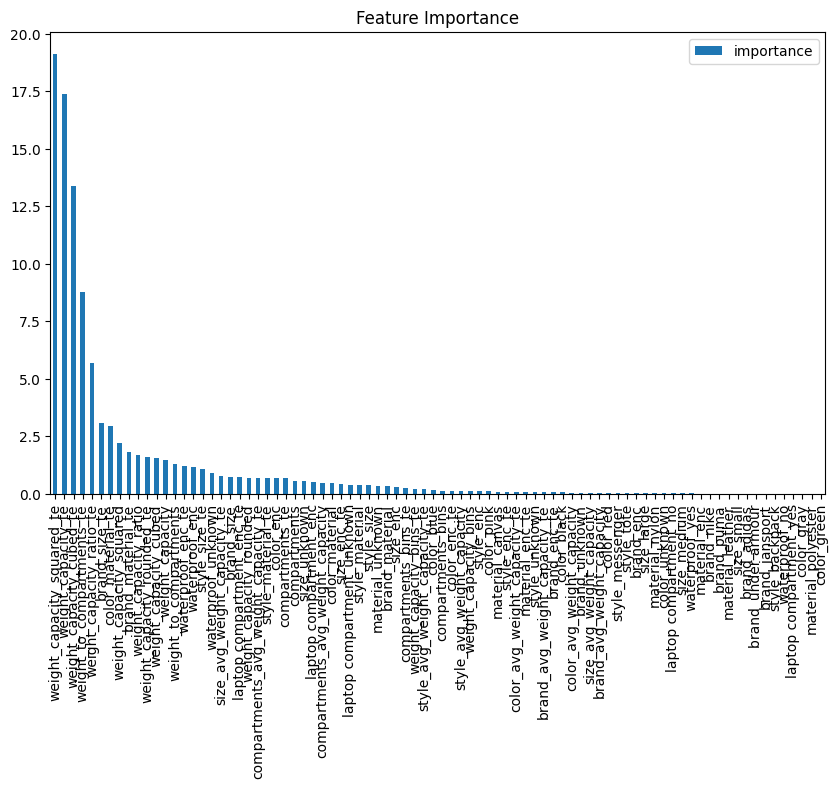

In [68]:
# plot feature importance of cat boost regressor

feature_importances = pd.DataFrame(best_cb.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)

feature_importances.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importance')
plt.show()

In [69]:
test['price'] = best_cb.predict(test[X.columns])

In [70]:
def create_submission_file(sub_df):
    submission = sub_df[['id', 'price']]
    submission = submission.rename(columns={'price': 'Price'})
    print(submission.isna().sum().sum())
    display(submission.head())
    file_name = datetime.now().strftime('submissions/submission_%Y%m%d_%H%M.csv')
    submission.to_csv(file_name, index = False)

In [71]:
create_submission_file(test)

0


,id,Price
0,300000,81.264218
1,300001,82.269699
2,300002,88.665935
3,300003,77.234253
4,300004,81.044276


In [81]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from keras import initializers
from keras.layers import BatchNormalization
from tensorflow.keras.constraints import MaxNorm
from kerastuner.tuners import Hyperband

from tensorflow.keras.optimizers import Adam


In [82]:
train_features = train[feature_cols]
train_labels = train['price']

test_features = test[feature_cols]
test_labels = test['price']

In [83]:
def build_model(hp):

  model = Sequential()

  # 0.3 to 0.4
  hp_dropout_1 = hp.Float('rate', min_value=0.3, max_value=0.4, step=0.1)
  model.add(BatchNormalization())
  model.add(Dropout(hp_dropout_1, input_shape=(train_features.shape[1],)))

  # Tune the number of dense layers
  for i in range(hp.Int('num_layers', 1, 3)):


    '''
    iterations of tuning nodes in each layer
    '''
    # hp_units = hp.Int('units_'+str(i), min_value=10, max_value=200, step=10)
    # hp_units = hp.Int('units_'+str(i), min_value=350, max_value=550, step=50)
    # hp_units = hp.Int('units_'+str(i), min_value=440, max_value=520, step=10)
    # hp_units = hp.Int('units_'+str(i), min_value=440, max_value=490, step=10)
    hp_units = hp.Int('units_'+str(i), min_value=440, max_value=490, step=10)

    # get max norm penalty for kernel for each layer
    # hp.Choice('maxnorm_kernel_constraint_'+str(i), values=[4.0, 5.0, 7.0, 10.0, 100.0])
    hp_penalty = hp.Choice('maxnorm_kernel_constraint_'+str(i), values=[3.0, 4.0, 5.0, 7.0])

    # hp_activation_function = hp.Choice('activation_function_'+str(i), values=['relu','leaky_relu','elu'])
    hp_activation_function = hp.Choice('activation_function_'+str(i), values=['elu'])

    model.add(Dense(units=hp_units, activation=hp_activation_function, kernel_constraint=MaxNorm(max_value=hp_penalty)))
    model.add(BatchNormalization())


    # .3 to .5
    hp_dropout_2 = hp.Float('rate_'+str(i), min_value=0.3, max_value=0.4, step=0.1)
    model.add(Dropout(hp_dropout_2))

  # Add dense output layer
  model.add(Dense(1, activation='linear'))

  # Tune the learning rate for the optimizer
  # hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  # hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])

  model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model

In [ ]:

# Define the early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor the validation loss
    min_delta=0.001,       # Minimum change to qualify as an improvement
    patience=10,           # How many epochs to wait before stopping
    restore_best_weights=True, # Restores model weights from the epoch with the best value of the monitored metric.
)

tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=200,
    factor=3, # factor that determines the number of halvings in the successive halving
    directory='hyperband_tuning_1',
    project_name='keras_model'
)

tuner.search(train_features, train_labels, epochs=200, validation_split=0.2, callbacks=[early_stopping])


Trial 10 Complete [03h 31m 21s]
val_loss: 1501.2200927734375

Best val_loss So Far: 1501.072509765625
Total elapsed time: 06h 10m 38s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
0.3               |0.3               |rate
3                 |1                 |num_layers
480               |480               |units_0
4                 |5                 |maxnorm_kernel_constraint_0
elu               |elu               |activation_function_0
0.3               |0.3               |rate_0
0.01              |0.001             |learning_rate
440               |None              |units_1
3                 |None              |maxnorm_kernel_constraint_1
elu               |None              |activation_function_1
0.4               |None              |rate_1
480               |None              |units_2
3                 |None              |maxnorm_kernel_constraint_2
elu               |None              |activation_function_2
0.4               |None            

/Users/andrewbennett/Documents/projects/backpack_price_prediction/.venv/lib/python3.12/site-packages/keras/src/layers/regularization/dropout.py:42: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
99858/99858 ━━━━━━━━━━━━━━━━━━━━ 18641s 187ms/step - loss: 1559.7306 - root_mean_squared_error: 39.4668 - val_loss: 1520.5568 - val_root_mean_squared_error: 38.9943
Epoch 2/3
99858/99858 ━━━━━━━━━━━━━━━━━━━━ 528s 5ms/step - loss: 1525.1782 - root_mean_squared_error: 39.0535 - val_loss: 1509.9457 - val_root_mean_squared_error: 38.8580
Epoch 3/3
57702/99858 ━━━━━━━━━━━━━━━━━━━━ 9:42 14ms/step - loss: 1516.0579 - root_mean_squared_error: 38.9366

KeyboardInterrupt: 

: 

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Summary of the best model
best_model.summary()

# Print the best hyperparameters
print('Best hyperparameters:', best_hyperparameters.values)
